# ARIMA 1: Auto correlation (ACF, PACF), Auto Regressive Models
- Revisão 
- Slide de intro aos modelos ARIMA/ARIMAX/SARIMAX
- Operador Lag
- Intro aos modelos AR
- Transformações para atingir estacionariedade
- ACF e PACF
- Ajuste de Modelos AR
- Modelos ARI

### Preparação


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.datasets import co2, get_rdataset
plt.rcParams["figure.figsize"] = [10, 3]
# Co2 (Tendência e Sazonalidade Aditiva)
co2_df = co2.load_pandas().data
co2_s = pd.Series(co2_df['co2'].ffill().resample('MS').mean(), name='Mauna Loa CO2')
# Air Passenger (Tendência e Sazonalidade Multiplicativa)
air_passengers = get_rdataset("AirPassengers").data
air_passengers.index = pd.date_range('1949', '1960-12', freq='MS')
airp_s = pd.Series(air_passengers['value'], name = 'Número de Passageiros')
# Séries com ações
file = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True).resample('MS').mean()
apple = pd.Series(closing_price['AAPL'], name='Preço de Fechamento Apple')
microsoft = pd.Series(closing_price['MSFT'], name='Preço de Fechamento Microsoft')
ibm = pd.Series(closing_price['IBM'], name='Preço de Fechamento IBM')
# Lancamentos Netflix
netf = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/netflix_titles.csv')
netf.index = pd.to_datetime(netf['date_added'], format='%B %d, %Y', errors = 'coerce')
lancamentos = netf.resample('MS').size()
netflix = pd.Series(lancamentos[lancamentos.index.year>2015],name='Lançamentos Netflix desde 2016')
# Lista com todas as séries
todas_series = [co2_s,airp_s,apple,microsoft,ibm, netflix]

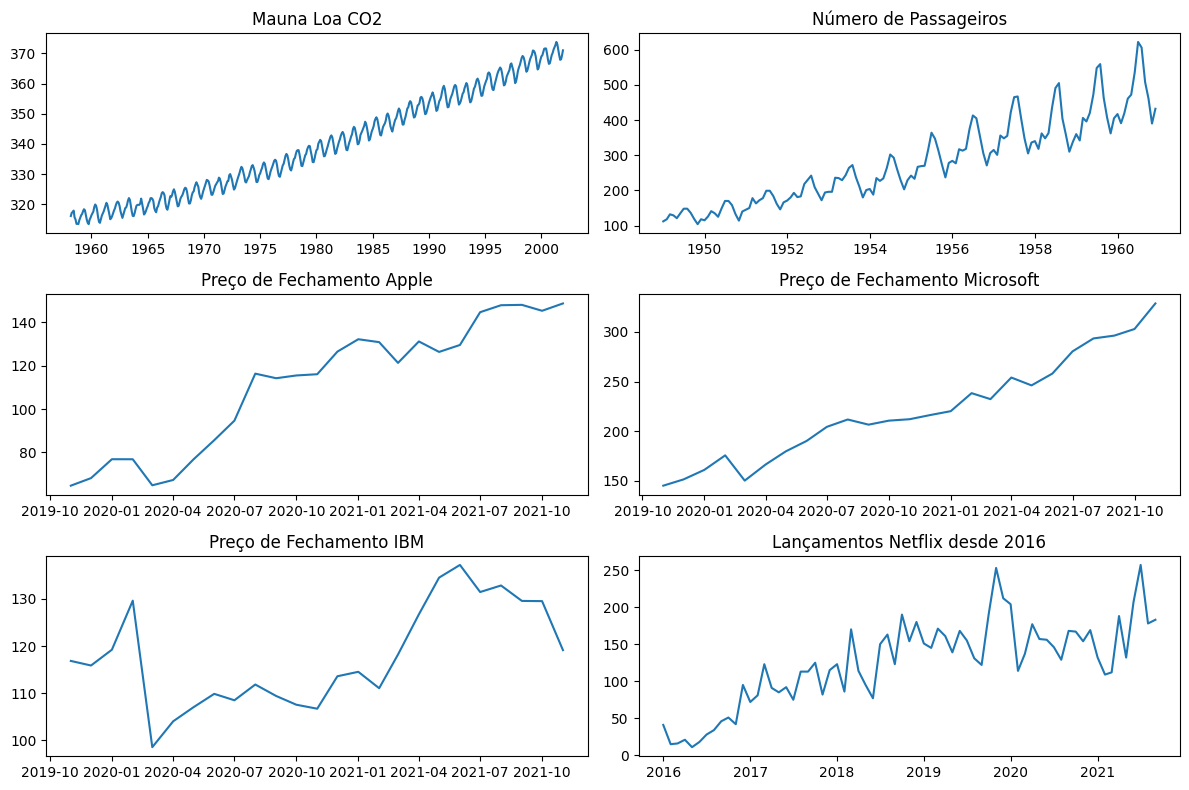

In [2]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes = axes.flatten()
for i,s in enumerate(todas_series):
    ax = axes[i]
    ax.plot(s)
    ax.set_title(s.name)
plt.tight_layout()
plt.show()

### Operador Lag

In [3]:
np.random.seed(42)
y = pd.Series(np.random.randint(0, 20, size=10), index=pd.date_range(start='2025-01-01', periods=10))
y

2025-01-01     6
2025-01-02    19
2025-01-03    14
2025-01-04    10
2025-01-05     7
2025-01-06     6
2025-01-07    18
2025-01-08    10
2025-01-09    10
2025-01-10     3
Freq: D, dtype: int64

In [4]:
y.shift(1)

2025-01-01     NaN
2025-01-02     6.0
2025-01-03    19.0
2025-01-04    14.0
2025-01-05    10.0
2025-01-06     7.0
2025-01-07     6.0
2025-01-08    18.0
2025-01-09    10.0
2025-01-10    10.0
Freq: D, dtype: float64

In [5]:
df = pd.DataFrame({'Y':y, 'Yminus1': y.shift(1), 'Yminus2': y.shift(2), 'Yminus3': y.shift(3), 'Yminus4': y.shift(4)})
df

,Y,Yminus1,Yminus2,Yminus3,Yminus4
2025-01-01,6,NaN,NaN,NaN,NaN
2025-01-02,19,6.0,NaN,NaN,NaN
2025-01-03,14,19.0,6.0,NaN,NaN
2025-01-04,10,14.0,19.0,6.0,NaN
2025-01-05,7,10.0,14.0,19.0,6.0
2025-01-06,6,7.0,10.0,14.0,19.0
2025-01-07,18,6.0,7.0,10.0,14.0
2025-01-08,10,18.0,6.0,7.0,10.0
2025-01-09,10,10.0,18.0,6.0,7.0
2025-01-10,3,10.0,10.0,18.0,6.0


### Intro aos modelos AR
$$ \large Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \epsilon_t $$

In [6]:
df = pd.DataFrame({'Y':y, 'X1': y.shift(1), 'X2': y.shift(2), 'X3': y.shift(3), 'X4': y.shift(4)})
df

,Y,X1,X2,X3,X4
2025-01-01,6,NaN,NaN,NaN,NaN
2025-01-02,19,6.0,NaN,NaN,NaN
2025-01-03,14,19.0,6.0,NaN,NaN
2025-01-04,10,14.0,19.0,6.0,NaN
2025-01-05,7,10.0,14.0,19.0,6.0
2025-01-06,6,7.0,10.0,14.0,19.0
2025-01-07,18,6.0,7.0,10.0,14.0
2025-01-08,10,18.0,6.0,7.0,10.0
2025-01-09,10,10.0,18.0,6.0,7.0
2025-01-10,3,10.0,10.0,18.0,6.0


In [7]:
from statsmodels.tsa.stattools import adfuller, kpss

def teste_estacionariedade(s):
    kps = kpss(s)
    adf = adfuller(s)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Estacionário', 'Não Estacionário'
    
    if adf_pv < 0.05:
        adfh = 'Estacionário'
    if kpss_pv < 0.05:
        kpssh = 'Não Estacionário'
    return (kpssh, adfh)

def mostra_series_com_testes(series, n_rows, n_cols,figsize=(12, 8)):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()
    for i,s in enumerate(series):
        ax = axes[i]
        ax.plot(s)
        ax.set_title(f'{s.name} - KPSS: {teste_estacionariedade(s)[0]} ADF: {teste_estacionariedade(s)[1]}', fontsize=10)
    plt.tight_layout()
    plt.show()

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_18900/4102516517.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(s)
/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_18900/4102516517.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(s)
/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_18900/4102516517.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(s)
/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_18900/4102516517.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-v

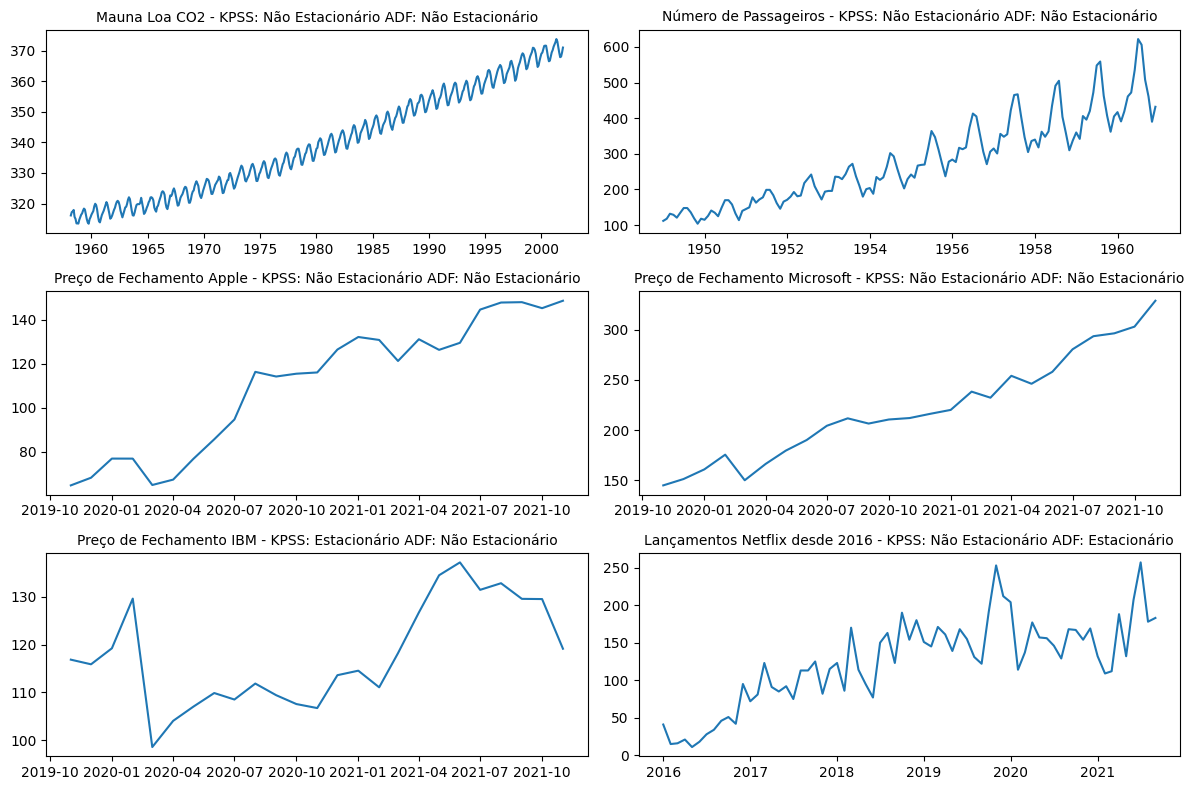

In [8]:
mostra_series_com_testes(todas_series,3,2)

## Transformações para atingir estacionariedade

- Diferenciação
    - Primeira Ordem
    - Segunda Ordem
    - Sazonal
- Log(Diferença Percentual)

### Diff Primeira Ordem

$$ \large y'_t = y_t - y_{t-1}  $$

In [9]:
serie_original = co2_s
primeira_ordem = serie_original.diff().dropna()
primeira_ordem

1958-04-01    1.100
1958-05-01    0.220
1958-06-01    0.480
1958-07-01   -2.275
1958-08-01   -0.665
              ...  
2001-08-01   -1.875
2001-09-01   -1.545
2001-10-01    0.170
2001-11-01    1.325
2001-12-01    1.645
Freq: MS, Name: Mauna Loa CO2, Length: 525, dtype: float64

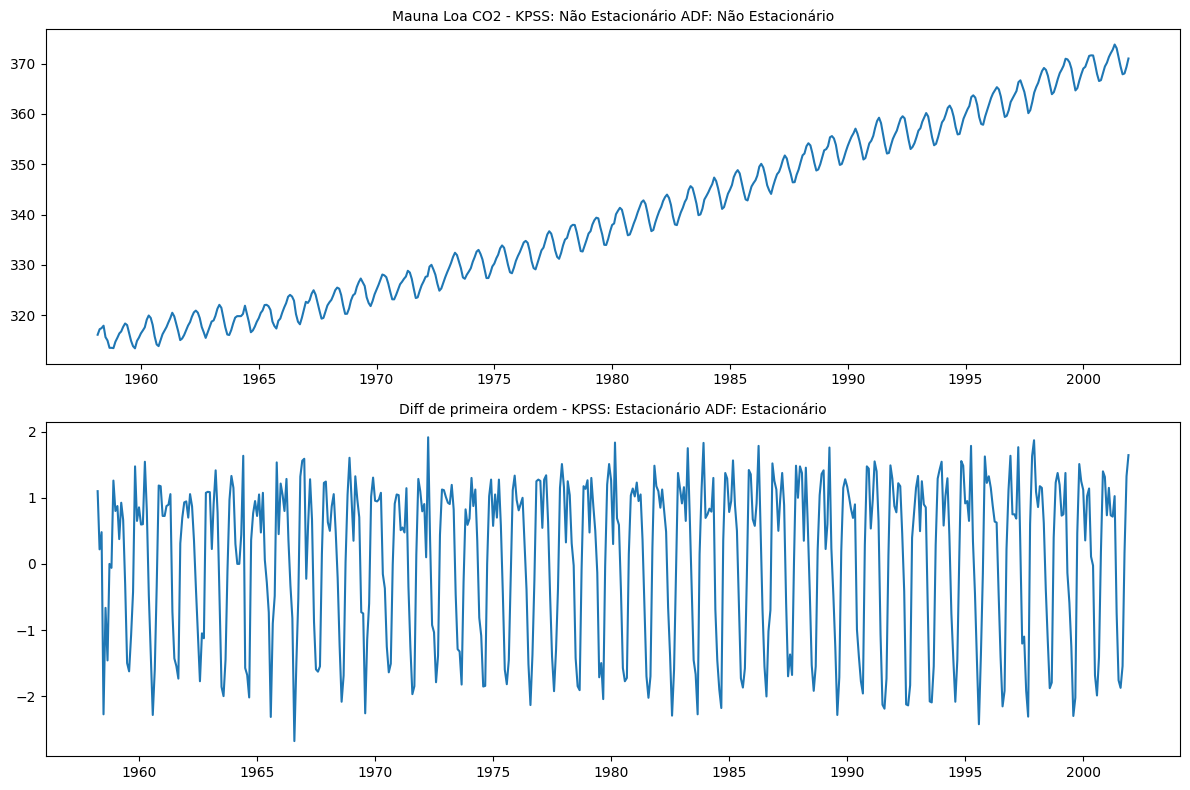

In [10]:
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.filterwarnings("ignore", category=InterpolationWarning)

primeira_ordem = pd.Series(primeira_ordem, name = 'Diff de primeira ordem')
series = [serie_original, primeira_ordem]
mostra_series_com_testes(series,2,1)

### Diff Segunda Ordem
$$ \large y'_t = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) $$

In [11]:
segunda_ordem = serie_original.diff().diff().dropna()
segunda_ordem = pd.Series(segunda_ordem, name = 'Diff de segunda ordem')

### Diff Sazonal
$$ \large y'_t = y_t - y_{t-12} $$

In [12]:
diff_sazonal = serie_original.diff(12).dropna()
diff_sazonal = pd.Series(diff_sazonal, name = 'Diff Sazonal')

### log diff

$$ \large y'_t = \log(y_t) - \log(y_{t-1}) = \log\left(\frac{y_t}{y_{t-1}}\right) $$

In [13]:
log_diff = np.log(serie_original/serie_original.shift(1)).dropna()
log_diff = pd.Series(log_diff, name = 'Diferença logarítmica')

### Box-Cox
$$ \large y_t^{(\lambda)} =
\begin{cases}
\frac{y_t^\lambda - 1}{\lambda}, & \lambda \neq 0 \\
\log(y_t), & \lambda = 0
\end{cases} $$

Box-Cox não retira tendência e só pode ser aplicada em séries positivas.

In [14]:
from scipy.stats import boxcox
boxcox_transform, lmbda = boxcox(serie_original)
boxcox_transform = pd.Series(boxcox_transform, index = serie_original.index, name = f'Box-Cox Transformation Lambda={round(lmbda,2)}')

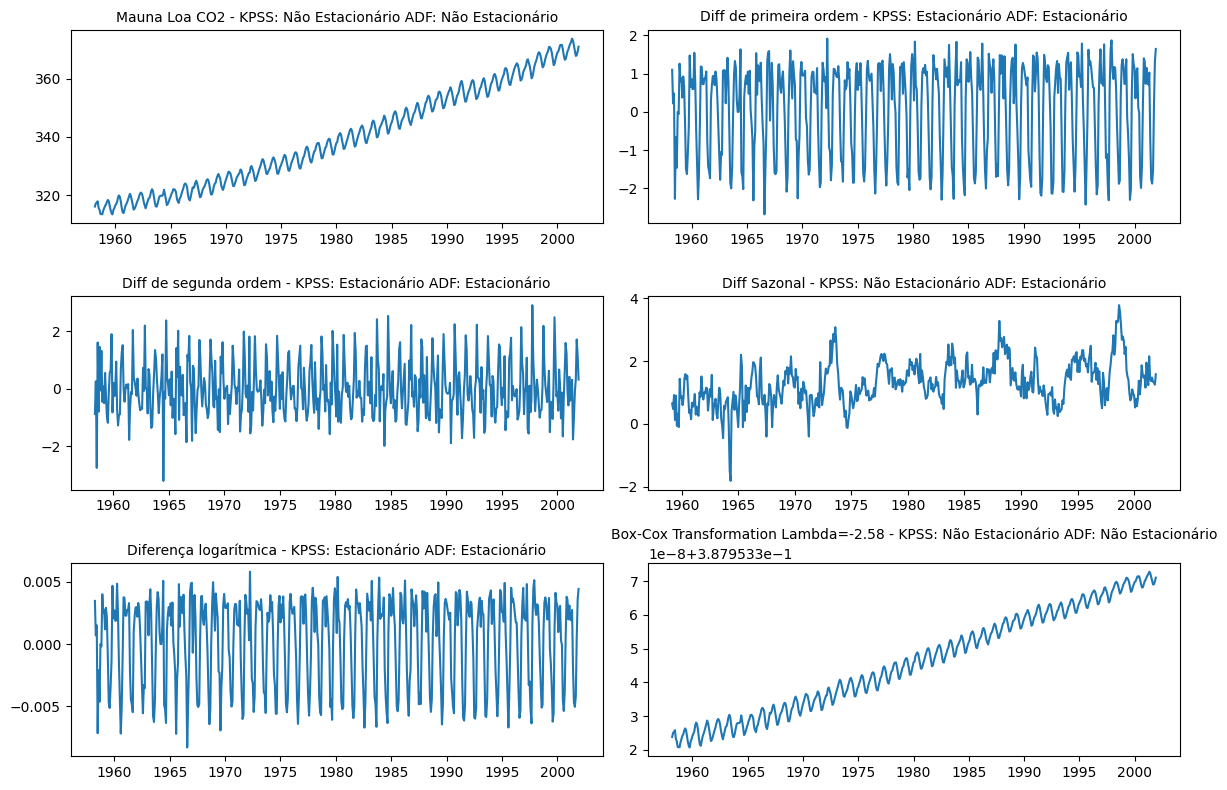

In [15]:
series = [serie_original, primeira_ordem, segunda_ordem, diff_sazonal, log_diff, boxcox_transform]
mostra_series_com_testes(series,3,2)

In [16]:
def testa_transformacoes(serie_original):
    primeira_ordem = serie_original.diff().dropna()
    primeira_ordem = pd.Series(primeira_ordem, name = 'Diff de primeira ordem')

    segunda_ordem = serie_original.diff().diff().dropna()
    segunda_ordem = pd.Series(segunda_ordem, name = 'Diff de segunda ordem')

    diff_sazonal = serie_original.diff(12).dropna()
    diff_sazonal = pd.Series(diff_sazonal, name = 'Diff Sazonal')

    log_diff = np.log(serie_original/serie_original.shift(1)).dropna()
    log_diff = pd.Series(log_diff, name = 'Diferença logarítmica')

    boxcox_transform, lmbda = boxcox(serie_original)
    boxcox_transform = pd.Series(boxcox_transform, index = serie_original.index, name = f'Box-Cox Transformation Lambda={round(lmbda,2)}')

    series = [serie_original, primeira_ordem, segunda_ordem, diff_sazonal, log_diff, boxcox_transform]
    mostra_series_com_testes(series,3,2)

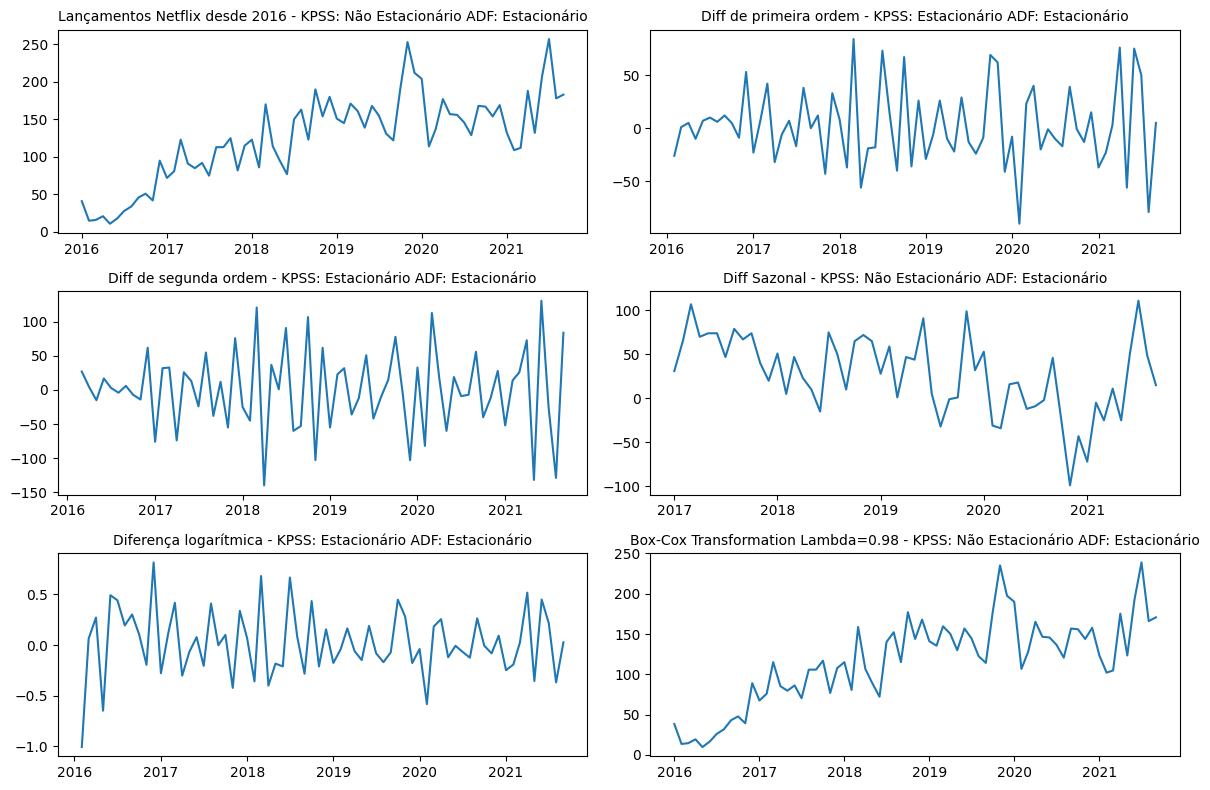

In [17]:
serie_original = netflix
testa_transformacoes(serie_original)

## ACF e PACF

Já vimos sobre o operador lag. Auto Correlação é a ideia de calcular a correlação da série com ela mesmo defasada. 

In [18]:
np.random.seed(42)
y = pd.Series(np.random.randint(0, 20, size=20), index=pd.date_range(start='2025-01-01', periods=20))
df = pd.DataFrame({'Y':y, 'Yminus1': y.shift(1), 'Yminus2': y.shift(2), 'Yminus3': y.shift(3), 'Yminus4': y.shift(4), 'Yminus5':y.shift(5)})
df

,Y,Yminus1,Yminus2,Yminus3,Yminus4,Yminus5
2025-01-01,6,NaN,NaN,NaN,NaN,NaN
2025-01-02,19,6.0,NaN,NaN,NaN,NaN
2025-01-03,14,19.0,6.0,NaN,NaN,NaN
2025-01-04,10,14.0,19.0,6.0,NaN,NaN
2025-01-05,7,10.0,14.0,19.0,6.0,NaN
2025-01-06,6,7.0,10.0,14.0,19.0,6.0
2025-01-07,18,6.0,7.0,10.0,14.0,19.0
2025-01-08,10,18.0,6.0,7.0,10.0,14.0
2025-01-09,10,10.0,18.0,6.0,7.0,10.0
2025-01-10,3,10.0,10.0,18.0,6.0,7.0


In [19]:
corr_matrix = df.corr(method='pearson')
corr_matrix[0:1]

,Y,Yminus1,Yminus2,Yminus3,Yminus4,Yminus5
Y,1.0,0.281563,0.031537,-0.206726,0.106213,0.258889


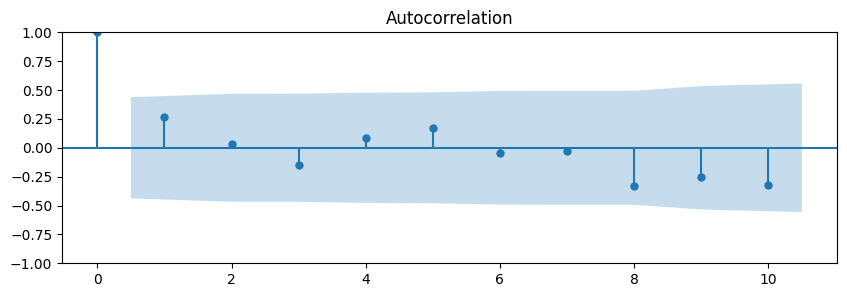

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y)
plt.show()

Ok, vamos olhar para uma série que possui auto correlações:

<Axes: >

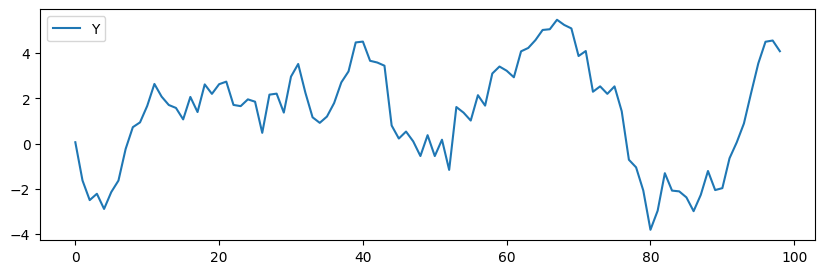

In [44]:
Y = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/AR1.csv')
Y.plot()

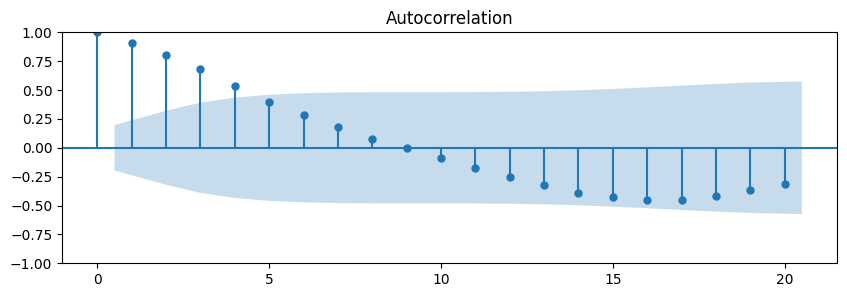

In [22]:
plot_acf(Y)
plt.show()

- ACF inclui todas as correlações entre os lags, mesmo as indiretas.
- PACF remove a influência dos defasagens intermediárias usando regressão e extraindo apenas o efeito direto de cada defasagem.
$$ Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_k Y_{t-k} + \epsilon_t $$

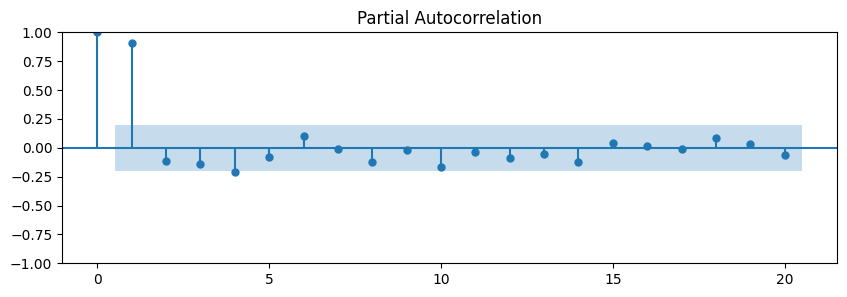

In [23]:
plot_pacf(Y)
plt.show()

### Testando se a série é um ruído branco

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox

co2_diff = co2_s.diff().dropna()
acorr_ljungbox(co2_diff, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,254.280444,3.028972e-57
2,286.262856,6.899389e-63
3,309.294120,9.686313e-67
4,419.200509,1.973445e-89
5,560.703885,6.236474e-119
6,699.552649,7.640231e-148
7,837.502814,1.494457e-176
8,941.655439,5.825382e-198
9,960.010148,7.216603e-201
10,992.522264,7.632487e-207


In [27]:
acorr_ljungbox(Y, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,83.937296,5.107190e-20
2,150.317090,2.285908e-33
3,198.822928,7.576894e-43
4,229.216804,1.946224e-48
5,245.652286,4.708437e-51
6,254.081882,5.501925e-52
7,257.529717,6.910309e-52
8,258.157812,3.208411e-51
9,258.159249,1.886395e-50
10,259.107421,6.586253e-50


Exemplo de ruído branco:

<Axes: >

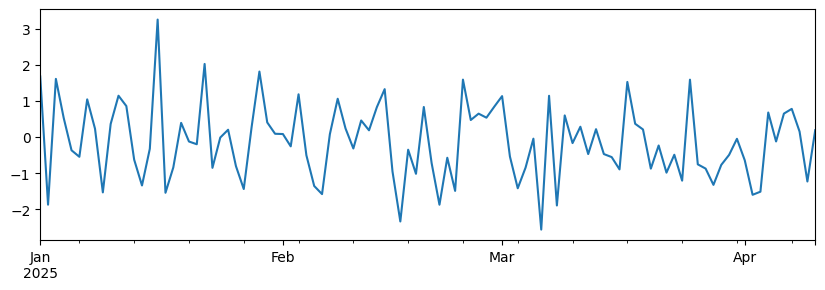

In [40]:
RB = pd.Series(np.random.normal(0, 1, 100), index=pd.date_range(start='2025-01-01', periods=100))
RB.plot()

In [41]:
acorr_ljungbox(RB, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,0.248691,0.617999
2,0.694224,0.706726
3,1.868688,0.600103
4,2.251492,0.689614
5,2.344544,0.799703
6,2.977398,0.811678
7,6.060903,0.532656
8,7.080253,0.527999
9,7.238042,0.612351
10,7.962836,0.632467


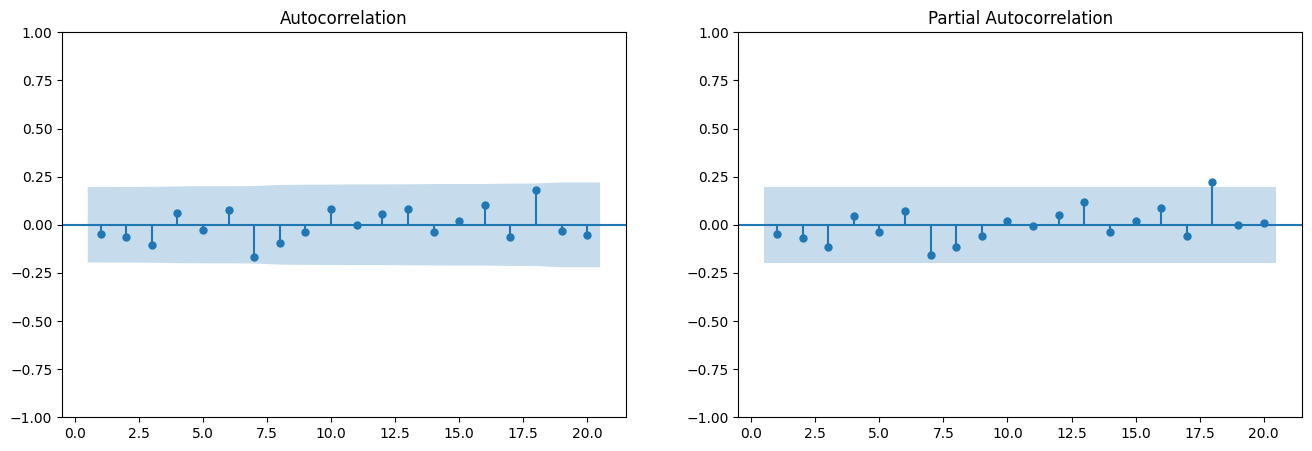

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(RB, zero=False, ax=ax[0])
plot_pacf(RB, zero=False, ax=ax[1])
plt.show()


### AR(1)

$$ \large Y_t = \phi_0 + \phi_1 Y_{t-1} + \epsilon_t $$

<Axes: >

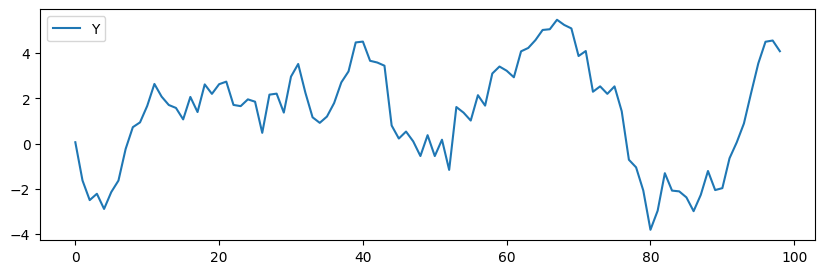

In [45]:
Y.plot()

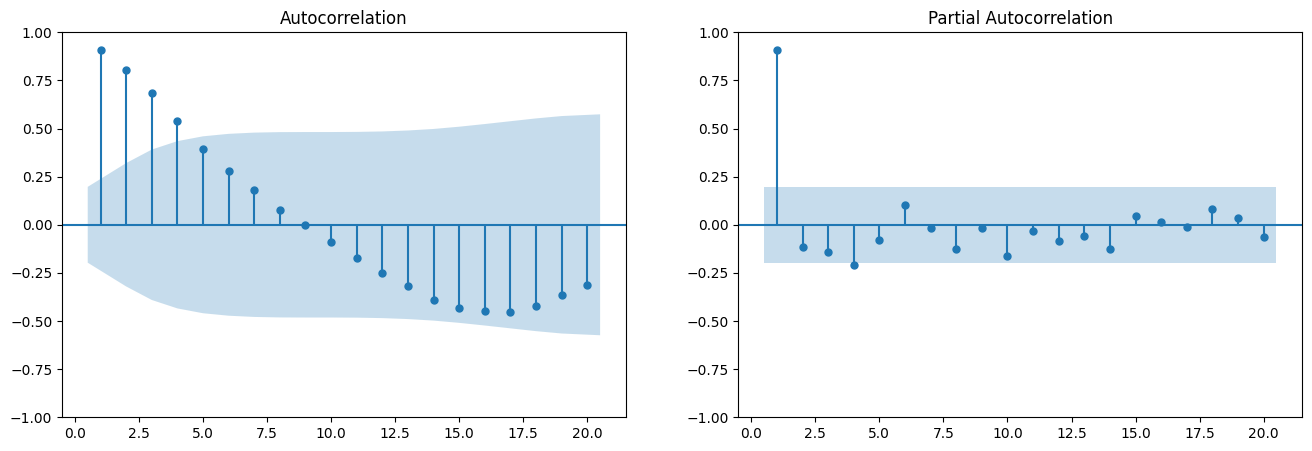

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(Y, zero=False, ax=ax[0])
plot_pacf(Y, zero=False, ax=ax[1])
plt.show()

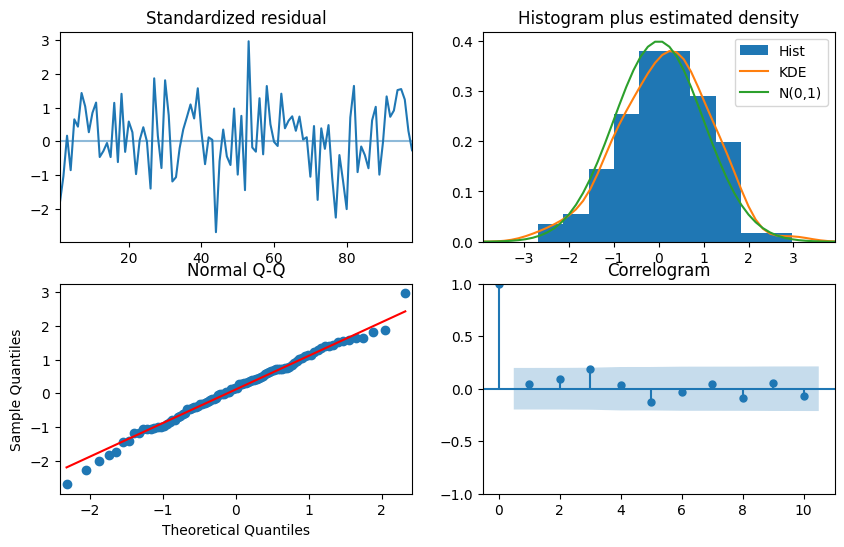

In [26]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(Y.dropna(), lags=1, trend='n').fit()
plt.rcParams["figure.figsize"] = [10, 6]
model.plot_diagnostics()
plt.show()

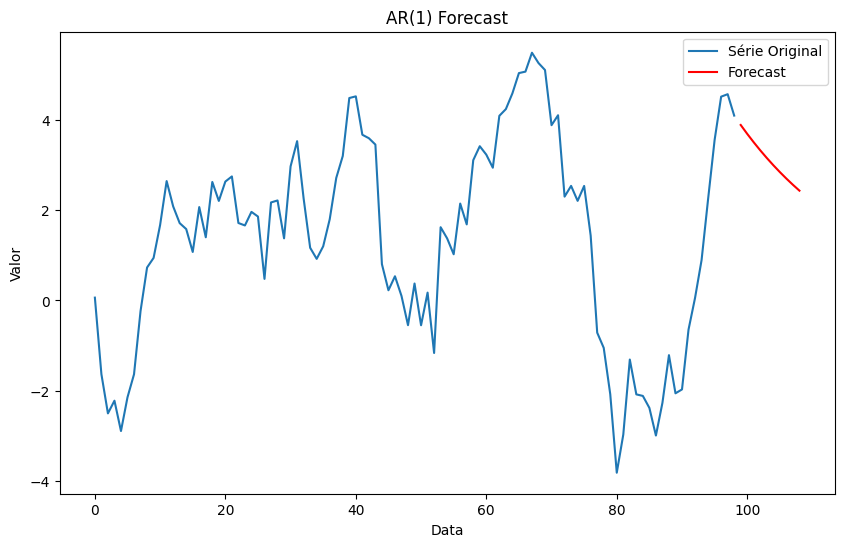

In [32]:
forecast_steps = 10
forecast = model.predict(start=len(Y), end=len(Y) + forecast_steps - 1)
plt.plot(Y, label='Série Original')
plt.plot(range(len(Y), len(Y) + forecast_steps), forecast, label='Forecast', color='red')
plt.legend()
plt.title('AR(1) Forecast')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [36]:
from scipy.stats import shapiro, boxcox, kstest, normaltest
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_goldfeldquandt, 
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad


In [34]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Não Normal'

In [42]:
serie_original = co2_s
normal_args = (np.mean(serie_original),np.std(serie_original))

print(is_normal(shapiro(serie_original)))
print(is_normal(normaltest(serie_original)))
print(is_normal(normal_ad(serie_original)))
print(is_normal(kstest_normal(serie_original)))
print(is_normal(kstest(serie_original, cdf='norm', args=normal_args)))

Não Normal
Não Normal
Não Normal
Não Normal
Não Normal


<Axes: >

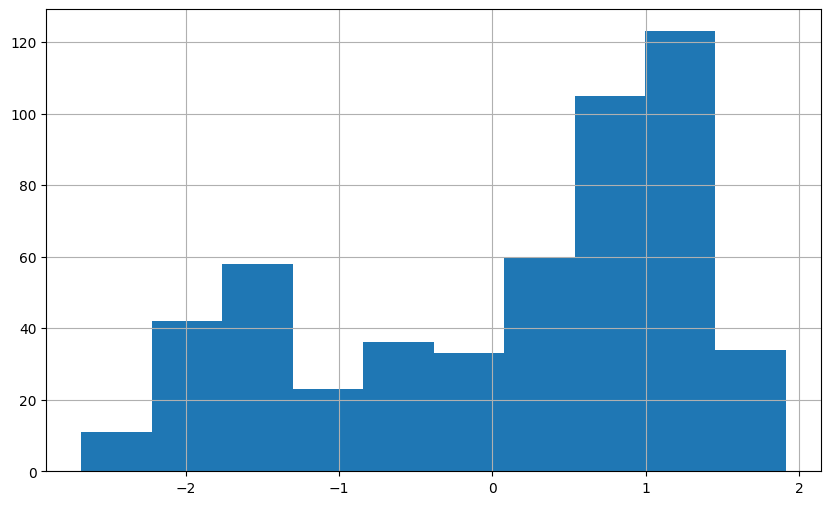

In [43]:
serie_original.diff().hist()

In [44]:
print(is_normal(shapiro(model.resid)))
print(is_normal(normaltest(model.resid)))
print(is_normal(normal_ad(model.resid)))
print(is_normal(kstest_normal(model.resid)))
print(is_normal(kstest(model.resid, 
                   cdf='norm', 
                   args=(np.mean(model.resid), np.std(model.resid)))))

Normal
Normal
Normal
Normal
Normal


In [46]:
model.test_normality()

Jarque-Bera    0.699841
P-value        0.704744
Skewness      -0.192415
Kurtosis       3.152628
dtype: float64

In [45]:
model.test_heteroskedasticity()

,ARCH-LM,P-value,DF
Lag,,,
1,0.236491,0.626752,1
2,1.667306,0.434459,2
3,1.544389,0.672064,3
4,2.979215,0.561310,4
5,4.830227,0.436949,5
6,5.781451,0.448112,6
7,6.282851,0.507138,7
8,7.807249,0.452522,8
9,14.692037,0.099750,9
